# Explanations Stability

In this notebook, we will explore how to calculate the stability of a local explanation for the Partial Effects explainer. We'll first start creating a classifier and fitting it with the iris data set. Then, we'll define the stability metric function and see how stable are the explanations.

This example was inspired by the usage of the stability metric in _Plumb, Gregory, Maruan, Al-Shedivat, Ángel Alexander, Cabrera, Adam, Perer, Eric, Xing, and Ameet, Talwalkar. "Regularizing Black-box Models for Improved Interpretability." . Advances in Neural Information Processing Systems (pp. 10526–10536). Curran Associates, Inc., 2020._

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp # v0.2.13

from sklearn import datasets
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

import warnings
warnings.filterwarnings(action='ignore',module=r'itea.*')

Let us start by loading the data set and fitting a simple classifier. Latter, the classifier will be used to explain a single instance and the stability of the explanation will be calculated for different sizes of neighborhoods.

In [2]:
iris_data = datasets.load_iris()
X, y      = iris_data['data'], iris_data['target']
labels    = iris_data['feature_names']
targets   = iris_data['target_names']

# changing numbers to the class names
y_targets = [targets[yi] for yi in y]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_targets, test_size=0.33, random_state=42)

# Creating transformation functions for ITEA using jax.numpy
# (so we don't need to analytically calculate its derivatives)
tfuncs = {
    'id'       : lambda x: x,
    'sqrt.abs' : lambda x: jnp.sqrt(jnp.abs(x)), 
    'log'      : jnp.log,
    'exp'      : jnp.exp
}

clf = ITEA_classifier(
    gens            = 50,
    popsize         = 50,
    max_terms       = 2,
    expolim         = (-1, 1),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = 'simplify_by_var',
    random_state    = 42,
).fit(X_train, y_train)

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.56 	 0.8482 	 0.97 	 0min17seg
5 	 0.74 	 0.9617999999999999 	 0.98 	 0min12seg
10 	 0.79 	 0.9693999999999999 	 0.99 	 0min12seg
15 	 0.95 	 0.9822 	 0.99 	 0min9seg
20 	 0.89 	 0.9822 	 0.99 	 0min10seg
25 	 0.86 	 0.9824 	 0.99 	 0min8seg
30 	 0.93 	 0.9818000000000001 	 0.99 	 0min6seg
35 	 0.96 	 0.9826000000000001 	 0.99 	 0min5seg
40 	 0.94 	 0.9816000000000001 	 0.99 	 0min3seg
45 	 0.66 	 0.9738 	 0.99 	 0min2seg


## Local explanations with the Partial Effects

To calculate the local explanations, we can use the function ``ITExpr_explainer.average_partial_effects``, passing as an argument a single sample we want to explain.

We can see the explanation both visually or as an array with the importance for each feature.

Let's start by creating an explainer instance.

**NOTE**: In the remaining of this notebook, all local explanations will be calculated over the first element of the test set.

In [3]:
explainer = ITExpr_explainer(
    itexpr=clf.bestsol_,
    tfuncs=tfuncs
).fit(X_train, y_train)

The visual inspection of feature importances can be useful in some cases:
* The features are ordered by the most important to the least important feature;
* The proportions between feature importances allows having a more clear understanding about its magnitudes;
* We can see how much each class is using each feature to make its classification.

It is important to notice that the prediction of the model is based on the class with the highest probability from the decision function. The decision function is a logit function using the IT expression as its linear model.

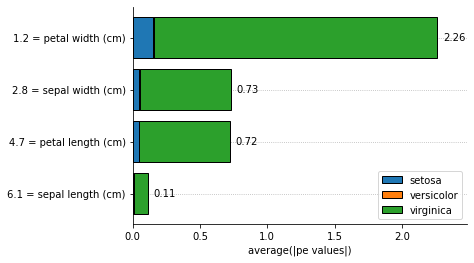

In [4]:
explainer.plot_feature_importances(
    X = X_test[0, :].reshape(1, -1),
    importance_method = 'pe',
    grouping_threshold = 0.0,
    target = None,
    barh_kw = {'edgecolor' : 'k'},
    show = True
)

We can use the ``average_partial_effects`` directly to obtain an array with numeric explanations, making it easy to manipulate the values to assess stabilities.

In [5]:
explainer.average_partial_effects(X_test[0, :].reshape(1, -1))

array([[6.85112219e-03, 5.00492617e-02, 4.76003440e-02, 1.51608147e-01],
       [2.74413002e-04, 3.40860669e-03, 1.31835324e-03, 6.55848291e-03],
       [1.03778588e-01, 6.74201575e-01, 6.71034697e-01, 2.10067814e+00]])

The function returns an array, where each line corresponds to the importance for each class. As we can see from the bar plot, the total importance for a given feature is the summation of the importance for each class:

In [6]:
np.sum(
    explainer.average_partial_effects(X_test[0, :].reshape(1, -1)),
    axis=0
)

array([0.11090412, 0.72765944, 0.71995339, 2.25884477])

## Stability of an explanation

In the mentioned paper, the authors discuss metrics to evaluate model agnostic explainers.

The stability measures how much the explanation changes when the feature slightly changes, where lower values are better. Higher values imply that, when the feature being explained changes in a small proportion, the feature importances responds in a much larger proportion, then the explainer is not reliable since it is not locally stable, and cannot be trusted for the given instance.

Let $f:\mathbf{x} \rightarrow y$, with $\mathbf{x} = \{x_0, x_1, ..., x_n\}$ be a model we want to explain, and $g: (f, \mathbf{x}_i) \rightarrow \mathbf{e}$ a explainer that takes a model and a instance to explain and attributes one feature importance for each $x \in \mathbf{x}_i$. 

The stability of the explanation is calculated by:

$$S(f, g, \mathbf{x}_i, \mathbf{N}_{\mathbf{x}_i}) = \mathbb{E}_{\mathbf{x}_j \sim \mathbf{N}_{\mathbf{x}_i}} \left [ || g(\mathbf{x}_i, f) - g(\mathbf{x}_j, f)||_{2}^{2} \right ].$$

In other words, the stability function evaluates the mean distance between the explanation for the original input and all sampled neighbors.

In [7]:
def explain_single(x):
    """wrapping the process to explain a single instance.
    
    The input x should be a single observation of shape (n_features, ).
    """
    
    return np.sum(
        explainer.average_partial_effects(x.reshape(1, -1)),
        axis=0
    )


def norm_p2(vector):
    """p2 norm of a vector.
    
    the vector should be an array of shape (n, ).
    """
    
    return np.sqrt(np.sum(np.abs(np.power(vector, 2))))


def stability(explainer, x, neighborhood):
    """Stability function.
    
    Takes as argument an explanation method, a single observation
    x of shape (n_features, ), and the neighborhood as a matrix of
    shape (n_neighbors, n_features), where each line is a sampled
    neighbor and each column is the feature value of the sample.
    
    Returns the mean squared p2-norm of the difference between the
    original explanation and every sampled neighbor.
    """
    
    original_explanation = explainer(x)
    return np.nanmean([
        norm_p2(explainer(nb) - original_explanation)**2
        for nb in neighborhood
    ])
        
    
def neighborhood(x, factor, size=100):
    """Method to create samples around a given observation x.
    
    This method uses a multivariate normal distribution to 
    randomly select feature values. The sigma of the distribution
    is calculated over the training data to mimic the original
    distributions and a scaling factor is multiplied to 
    adjust how large will be the neighborhood.
    
    It is possible to specify the number of generated samples
    by setting the size to a different value (default=100).
    
    Returns a matrix of shape (size, n_features) containing
    the sampled neighbors.
    """
    
    cov = np.cov(X_train.T)

    return np.random.multivariate_normal(x, cov*factor, size=size)

In [8]:
stability(
    explain_single,
    X_test[0],
    neighborhood(X_test[0], 0.001)
)

0.0071261048289940334

## Increasing the neighborhood to measure stability

In the original work, the authors used fixed values for creating the neighborhood to evaluate stability.

I think this can be limiting in some situations. To verify, we will evaluate how stability changes when we increase the size of the neighborhood.

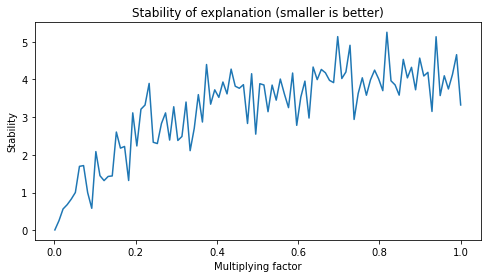

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

factors = np.linspace(0.001, 1, 100)

axs.plot(
    factors,
    [stability(
        explain_single,
        X_test[0],
        neighborhood(X_test[0], factor, size=20)
    ) for factor in factors]
)

axs.set_title("Stability of explanation (smaller is better)")
axs.set_ylabel("Stability")
axs.set_xlabel("Multiplying factor")

plt.show()

## The Jaccard Index

In _Zhengze Zhou, Giles Hooker, Fei Wang. "S-LIME: Stabilized-LIME for Model Explanation".	In Proceedings of the 27th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD '21), August 14--18, 2021, Virtual Event, Singapore_, the authors used the Jaccrd index to evaluate the stability of a function.

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}.$$

This method ignores ordering, and is only concerned if the most important features will always be the same. Values close to 1 means that the algorithm is stable accros different iterations.

The Jaccard index is the ratio of the intersection over the union of two data sets. In the paper, to evaluate the stability for aa given test instance $t$, they:
1. Execute the explanation method 20 times;
2. Saved the $k$ most important features (with $k=\{1, 2, 3, 4, 5\}$);
3. For each value of $k_i$, the $k_i$ most important features for each execution were used to calculate the Jaccard index across all possible pairs (20*19 pairs), then the average was reported.

Their result look like this:

| k | Jaccard Index for the method |
|---|:----------------------------:|
| 1 |             1.0              |
| 2 |             0.2              |
| 3 |             0.8              |
| 4 |             0.7              |
| 5 |             0.0              |


### Adaptating the Jaccard Index

In the cell below the Jaccard Index is used to evaluate stability, but since the Partial Effects explanation method is deterministic, the calculation will be performed on the neighborhood of the test point. We can use ``explain_single`` and ``neighborhood`` functions previously declared.

In [10]:
def jaccard_index(A, B):
    """Method to calculate the ratio of the intersection
    over the union of two sets. This is known as Jaccard
    index and ranges from 0 to 1, measuring how simmilar
    the two sets are. A value equals to 1 means that the 
    sets are identical (remembering that sets does not
    have order relations between its elements), and a 
    value equals to 0 means that they are completely
    different. 
    
    Takes as argument two python built-in sets A and B.
    
    Returns a float number representing the Jaccard Index.
    """
    
    return len(A.intersection(B)) / len(A.union(B))


def get_k_most_important(explanation, k):
    """Method that takes an array of explanation and 
    returns the index of the k most important (highest)
    values in the array.
    
    Takes an array of explanations of shape (n_features, )
    and an integer k representing the size of the subset,
    k <= len(explanations).
    
    Returns a python built-in set containing the indexes
    of the k highest values.
    """
    
    # Reversing the order so its in descending order
    order = np.argsort(explanation)[::-1]

    
    return set(order[:k])
    

def jaccard_stability(explainer, x, neighborhood, k):
    """Jaccard adaptation Stability function.
    
    Takes as argument an explanation method, a single observation
    x of shape (n_features, ), the neighborhood as a matrix of
    shape (n_neighbors, n_features), and the size of the subset being
    considered k
    
    Returns the mean Jaccard Index between the original sample
    and all neighbors, considering how similar the k most important
    subset of features between the explanation of the original data
    and its neighbors.
    """
    
    original_explanation = explainer(x)
    original_jaccard_set = get_k_most_important(original_explanation, k)
    
    return np.nanmean([
        jaccard_index(
            get_k_most_important(explainer(nb), k),
            original_jaccard_set
        )
        for nb in neighborhood
    ])

In te cell below we create a table similar to the one reported in the S-LIME paper. For different multiplication factors that adjusts the size of the neighborhood, we can see how stable the explanations are in terms of returning the same most important features.

Notice that the maximum number of features is 4.

In [11]:
ks = [1, 2, 3, 4]
fs = [0.001, 0.01, 0.1, 1.0]

jaccard_df = pd.DataFrame(
    data   = [[jaccard_stability(explain_single, X_test[0], neighborhood(X_test[0], f, size=100), k=k)
              for k in ks] for f in fs],
    index   = [f'factor {f}' for f in fs],
    columns = [f'k={k}' for k in ks]
)

display(jaccard_df)

,k=1,k=2,k=3,k=4
factor 0.001,1.00,0.753333,1.000,1.0
factor 0.01,1.00,0.686667,1.000,1.0
factor 0.1,1.00,0.666667,0.995,1.0
factor 1.0,0.89,0.660000,0.940,1.0
